In [81]:
import sys
sys.path.append('../')
import sqlite3
import json
from backtester import *
from fxcmtoken import major_forex_pairs
from sklearn.model_selection import train_test_split
from datetime import datetime

In [82]:
major_forex_pairs

['EUR/USD', 'GBP/USD', 'USD/JPY', 'USD/CHF', 'USD/CAD', 'AUD/USD', 'NZD/USD']

In [83]:
freq = 'm15'
conn = sqlite3.connect(f'../PriceData/PriceData_{freq}.db')
ticker = major_forex_pairs[4]
print(ticker)
data = pd.read_sql(f"SELECT * FROM '{ticker}'", conn, parse_dates=['date'], index_col=['date'])
conn.close()
columns = ['open', 'high', 'low', 'close']
for col in columns:
    data[col] = data[['bid'+col, 'ask'+col]].mean(axis=1)
display(data)
test_size = 0.048
test_len = int(test_size * len(data))

USD/CAD


,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,open,high,low,close
date,,,,,,,,,,,,,
2021-07-16 06:30:00,1.25715,1.25770,1.25796,1.25709,1.25737,1.25791,1.25816,1.25731,818,1.257260,1.258060,1.257200,1.257805
2021-07-16 06:45:00,1.25770,1.25741,1.25818,1.25730,1.25791,1.25761,1.25838,1.25751,891,1.257805,1.258280,1.257405,1.257510
2021-07-16 07:00:00,1.25741,1.25742,1.25812,1.25725,1.25761,1.25763,1.25833,1.25746,1697,1.257510,1.258225,1.257355,1.257525
2021-07-16 07:15:00,1.25742,1.25821,1.25823,1.25736,1.25763,1.25842,1.25842,1.25755,1429,1.257525,1.258325,1.257455,1.258315
2021-07-16 07:30:00,1.25821,1.25910,1.25922,1.25818,1.25842,1.25929,1.25943,1.25839,1812,1.258315,1.259325,1.258285,1.259195
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-08 11:30:00,1.26385,1.26359,1.26426,1.26351,1.26404,1.26381,1.26446,1.26372,2745,1.263945,1.264360,1.263615,1.263700
2021-12-08 11:45:00,1.26360,1.26180,1.26381,1.26172,1.26381,1.26202,1.26402,1.26193,8288,1.263705,1.263915,1.261825,1.261910
2021-12-08 12:00:00,1.26180,1.26253,1.26283,1.26144,1.26201,1.26273,1.26305,1.26166,3619,1.261905,1.262940,1.261550,1.262630


In [84]:
roll_period = 100
pct = 0.001
data['max'] = data['close'].rolling(roll_period).max()
data['min'] = data['close'].rolling(roll_period).min()
data['mean'] = data[['max', 'min']].mean(axis=1)
data['maxbound'] = data['max']*(1-pct) 
data['minbound'] = data['min']*(1+pct)
data['uppermean'] = data['mean']*(1+pct)
data['lowermean'] = data['mean']*(1-pct)
data.dropna(inplace=True)

<AxesSubplot:xlabel='date'>

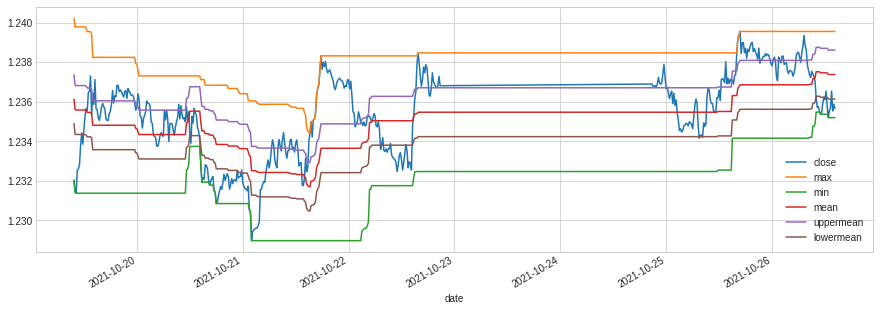

In [85]:
data[['close', 'max', 'min', 'mean', 'uppermean', 'lowermean']][-3500:-3000].plot(figsize=(15,5))

In [86]:
data['signal'] = np.where(data['close'] > data['uppermean'], 1,
                          np.where(data['close'] < data['lowermean'], -1, np.nan))

In [87]:
data['signal'] = data['signal'].ffill().fillna(0).mul(-1)

In [88]:
if data.shape[0] > test_len:
    data = data.iloc[-test_len:]
else:
    pass

In [89]:
print('*** Positions ***')
print(data['signal'].value_counts())
print('-'*50)
print('*** Trades ***')
print(data['signal'].diff(1).apply(np.abs).value_counts())

*** Positions ***
-1.0    260
 1.0    220
Name: signal, dtype: int64
--------------------------------------------------
*** Trades ***
0.0    475
2.0      4
Name: signal, dtype: int64


  0%|          | 0/479 [00:00<?, ?it/s]

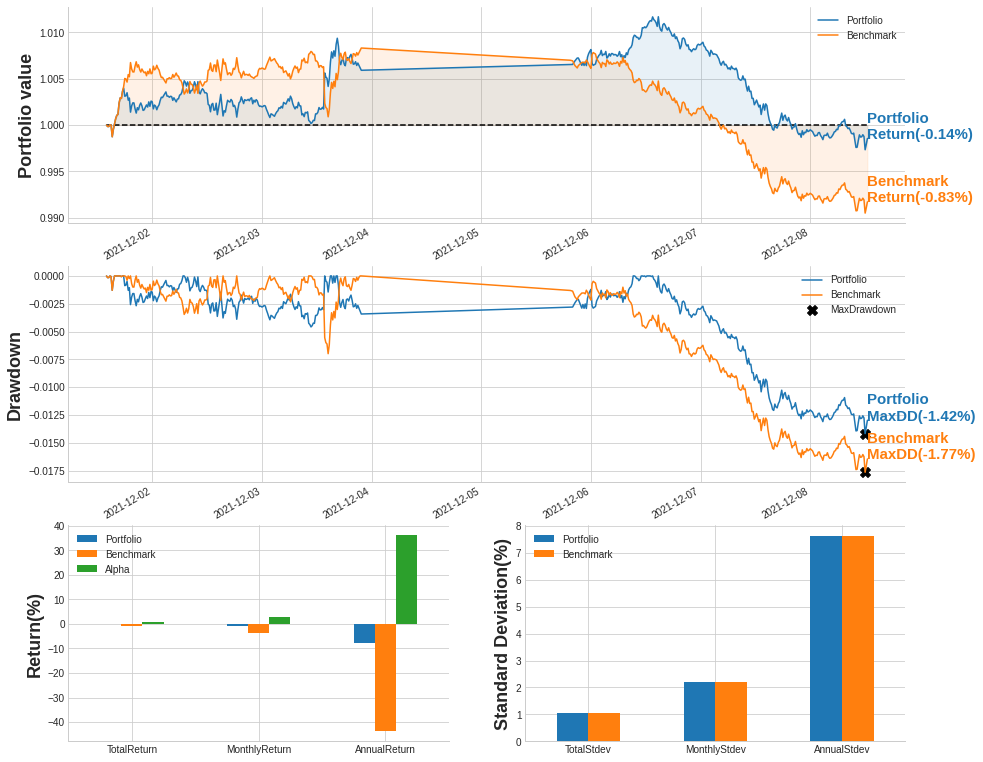

----------------------------------------------------------------------
Data length: |6 days 22:30:00|
Data range from |2021-12-01 14:00:00| to |2021-12-08 12:30:00|
----------------------------------------------------------------------
***** Portfolio Returns in percentage(%) *****
╒═══════════════╤═════════════╤═════════════╤═════════╕
│               │   Portfolio │   Benchmark │   Alpha │
╞═══════════════╪═════════════╪═════════════╪═════════╡
│ TotalReturn   │      -0.144 │      -0.833 │   0.689 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ MonthlyReturn │      -0.625 │      -3.604 │   2.979 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ AnnualReturn  │      -7.602 │     -43.845 │  36.243 │
╘═══════════════╧═════════════╧═════════════╧═════════╛
***** Portfolio Standard Deviation in percentage(%) *****
╒══════════════╤═════════════╤═════════════╕
│              │   Portfolio │   Benchmark │
╞══════════════╪═════════════╪═════════════╡
│ TotalStdev   │    

In [90]:
backtest = IterativeBacktester(data=data,
                               signals=data['signal'],
                               freq=freq)
backtest.backtest()
backtest.results()